# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from torchvision import datasets, transforms, models

data_dir = 'CIFAR10'

#Define transforms

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])


test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])  
                                    ])

# Create training set and define training dataloader
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

# Create test set and define test dataloader
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([8, 3, 32, 32])
torch.Size([8])


We can see below that images is just a tensor with size (64, 3, 224, 224). So, 64 images per batch, 3 color channels (RGB), and 224x224 images

In [4]:
#for batch_idx, samples in enumerate(trainloader):
      #print(batch_idx, samples)

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        std = (.5, .5, .5)
        mean = (.5, .5, .5)
        for i in range(3):
            image[i]=std[i]* image[i] + mean[i]
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

bird


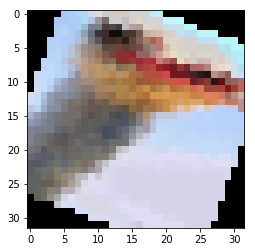

frog


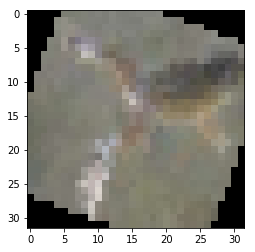

deer


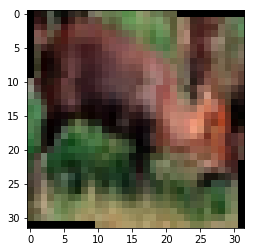

truck


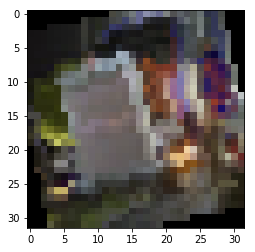

car


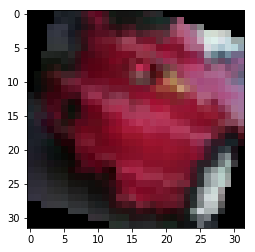

In [6]:
# Explore data
show5(trainloader)

In [7]:
def imshow(img):    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
for images, labels in trainloader:
    #imshow(images[0])
    print(images[0])
    print(classes[labels[0].item()])
    break

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [9]:
# from torch import nn, optim
# import torch.nn.functional as F
# 
# class CifarModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(3072, 768)
#         self.fc2 = nn.Linear(768, 10)
        
        
#         self.dropout = nn.Dropout(p=0.2)
        
#     def forward(self, x):
#         # make sure input tensor is flattened
#         x = x.view(x.shape[0], -1)
        
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = F.log_softmax(self.fc2(x), dim=1)
        
#         return x

# model = CifarModel()
# model.to(device)

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
        self.fc1 = nn.Linear(1024, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
model = Net()

In [21]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [22]:
criterion =nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [23]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [24]:
## YOUR CODE HERE ##

import time
start = time.time()
# For long running code keep the session active
#with active_session():
    

model.to(device)
epochs = 5
steps = 0
#running_loss = 0
#run_accuracy = 0

train_losses, tune_losses = [], []
train_accuracy, tune_accuracy = [], []

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    running_corrects = 0.0
    test_running_corrects = 0.0
    for images, labels in trainloader:
        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps, labels)
        
        loss.backward()
        optimizer.step()

        #print(loss.item())
        train_loss += loss.item()
        _, preds = torch.max(logps, 1)
        running_corrects += torch.sum(preds == labels.data)
    else:
        with torch.no_grad():
            for images_test, labels_test in testloader:
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                output_test = model(images_test)
                test_loss = criterion(output_test, labels_test)

                _, test_preds = torch.max(output_test, 1)
                valid_loss += test_loss.item()
                test_running_corrects += torch.sum(test_preds == labels_test.data)  

        epoch_loss = train_loss/len(trainloader)
        epoch_acc = running_corrects.float()/ 50000
        train_losses.append(epoch_loss) 
        train_accuracy.append(epoch_acc)

        test_epoch_loss = valid_loss/len(testloader)
        test_epoch_acc = test_running_corrects.float()/10000
        tune_losses.append(test_epoch_loss)
        tune_accuracy.append(test_epoch_acc)

        print('Epoch: {}\nTraining loss: {:.4f},Training accuracy {:.4f} '.format(epoch + 1,epoch_loss, epoch_acc.item()))
        print('Validation loss: {:.4f}, Validation accuracy {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))
        
print('Finished Training')
end = time.time()
print(f'Tid: {end - start}')

Epoch: 1
Training loss: 1.5443,Training accuracy 0.4363 
Validation loss: 1.2842, Validation accuracy 0.5278 
Epoch: 2
Training loss: 1.3088,Training accuracy 0.5297 
Validation loss: 1.2211, Validation accuracy 0.5597 
Epoch: 3
Training loss: 1.2331,Training accuracy 0.5630 
Validation loss: 1.1545, Validation accuracy 0.5840 
Epoch: 4
Training loss: 1.1943,Training accuracy 0.5743 
Validation loss: 1.0884, Validation accuracy 0.6241 
Epoch: 5
Training loss: 1.1653,Training accuracy 0.5862 
Validation loss: 1.0912, Validation accuracy 0.6173 
Finished Training
Tid: 248.6845133304596


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

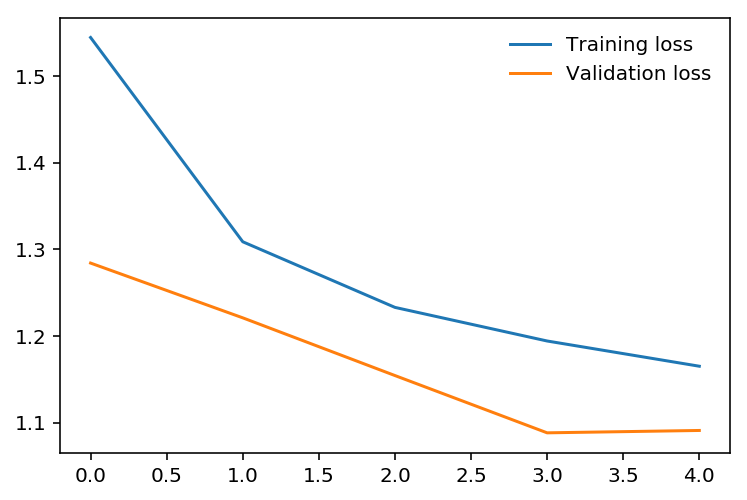

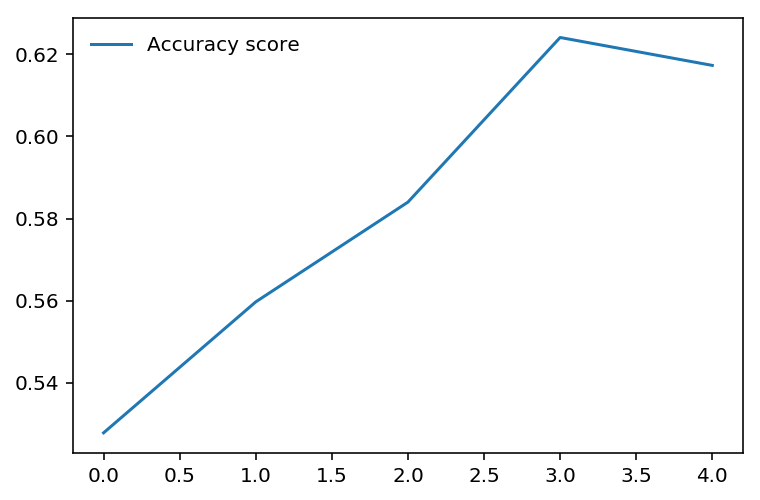

In [26]:
## YOUR CODE HERE ##

plt.plot(train_losses, label='Training loss')
plt.plot(tune_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()



plt.plot(tune_accuracy, label='Accuracy score')
plt.legend(frameon=False)
plt.show()

In [27]:
#

Plot the training loss (and validation loss/accuracy, if recorded).

In [29]:
## YOUR CODE HERE ##
import numpy

print("Highest Accuracy score: {:.3f}%.\t ".format(max(tune_accuracy)*100),
      "Average Train Loss: {:.3f}.\t ".format(numpy.mean(train_losses)),
      "Average Test Loss: {:.3f}. ".format(numpy.mean(tune_losses)))

Highest Accuracy score: 62.410%.	  Average Train Loss: 1.289.	  Average Test Loss: 1.168. 


Our model: 

 Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [31]:
## YOUR CODE HERE ##
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [33]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [34]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?


The Best Accuracy is 62% , while the Delta Corps accuracy is above 70% given the Time contraints we were able to develop a model with a decent accuracy. Given the fact if we had more time , defientely we will be able to beat the accuracy of Delta crop. 

Other Models have a significantly greater accuracy greater than 95% , which is way of than our model accuracy. 

I used CNN model to achieve a good accuracy , reason why i used CNN model is because CNN is an algorithm used to recognize patterns in data , this algorithm excel in Image classification task. Initially the model was created with only the Simple Layers , model was not able to classify the images as expected. Accuracy was so poor hence i used CNN model to increase the accuracy 


Yes currently , Accuracy have to be increased it has only 62% , we can read about the more advanced models whihc has more 95% and try to understand their network or we can leverage the Transfer learning to improve the accuracy. 


**Double click this cell to modify it**



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).